In [140]:
import tensorflow as tf
from matplotlib import pyplot as plt

def f(x):
    return tf.sin(x) * 8 + .5

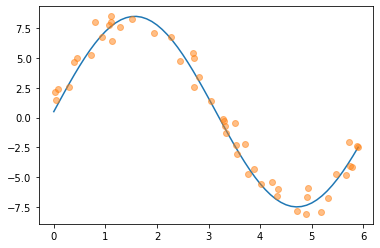

In [141]:
# 先构建一些测试数据
tf.random.set_seed(32)
# 训练集
n_train = 50
x = tf.random.uniform((n_train, ), maxval=6)
y = f(x) + tf.random.normal((n_train, ), mean=0, stddev=1)
# 测试集
x_test = tf.range(0, 6, .1)
y_test = f(x_test)
n_test = len(x_test)

def _plot(y_test_pred=None):
    # 测试集
    plt.plot(x_test, y_test)
    # 测试集上的预测值
    if y_test_pred is not None:
        plt.plot(x_test, y_test_pred)
    # 训练集
    plt.plot(x, y, 'o', alpha=.5)
_plot()

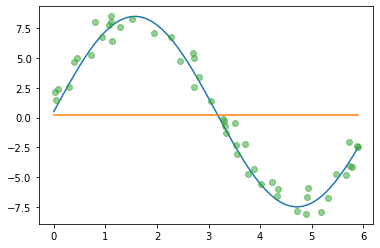

In [145]:
# 先使用avgpool模拟attentionpool
# 每一个预测值直接从y生成，此时的attentionpool就相当于没有注意力，并且忽略了x
y_hat = tf.repeat(tf.reduce_mean(y), repeats=n_test)
_plot(y_hat)